In [1]:
from itertools import combinations, combinations_with_replacement, product

import tskit
import msprime
import numpy as np

In [112]:
ts = msprime.sim_ancestry(samples=4, recombination_rate=.2, sequence_length=10, random_seed=1)  # seed=2 is a trickier test that is helpful for testing mrca correctness

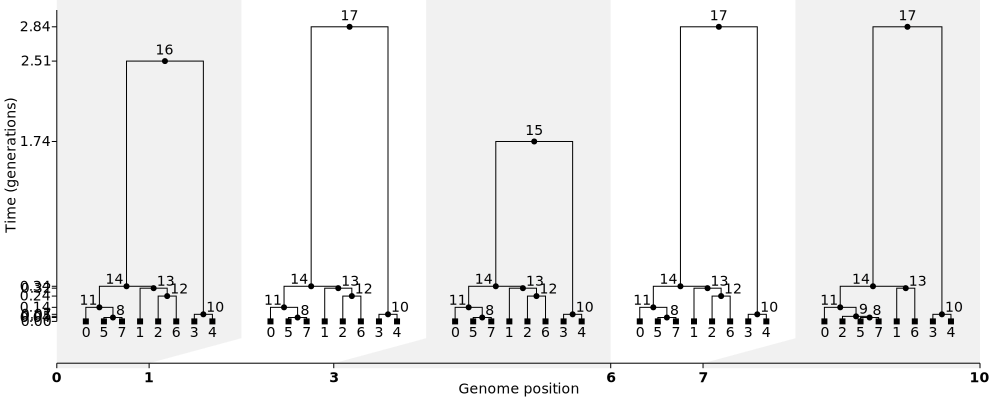

In [113]:
ts.draw_svg(y_axis=True, size=(1000,400))

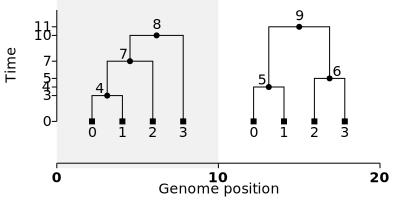

In [127]:
import io
import tskit

nodes = """\
is_sample time
1         0
1         0
1         0
1         0
0         3
0         4
0         5
0         7
0         10
0         11
"""

edges = """\
left   right   parent  child
0      10      4       0,1
0      10      7       2,4
0      10      8       3,7
10     20      5       0,1
10     20      6       2,3
10     20      9       5,6
"""

# sites = """\
# position ancestral_state
# """

# mutations = """\
# site node parent derived_state
# """

ts = tskit.load_text(
    nodes=io.StringIO(nodes),
    edges=io.StringIO(edges),
    # sites=io.StringIO(sites),
    # mutations=io.StringIO(mutations),
    strict=False,
)

ts.draw_svg(y_axis=True)

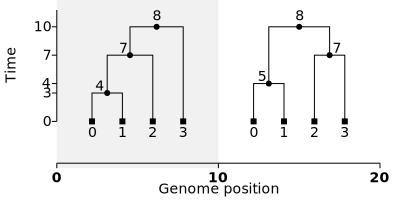

In [120]:
import io
import tskit

nodes = """\
is_sample time
1         0
1         0
1         0
1         0
0         3
0         4
0         5
0         7
0         10
"""

edges = """\
left   right   parent  child
0      10      4       0,1
0      10      7       2,4
0      10      8       3,7
10     20      5       0,1
10     20      7       2,3
10     20      8       5,7
"""

# sites = """\
# position ancestral_state
# """

# mutations = """\
# site node parent derived_state
# """

ts = tskit.load_text(
    nodes=io.StringIO(nodes),
    edges=io.StringIO(edges),
    # sites=io.StringIO(sites),
    # mutations=io.StringIO(mutations),
    strict=False,
)

ts.draw_svg(y_axis=True)

In [128]:
from itertools import groupby
def print_mrcas(mrcas):
    """print MRCAs in a format that's easy to verify by eye"""
    [list(v) for k, v in groupby(sorted(mrcas.items(), key=lambda p: p[1]), key=lambda p: p[1])]

In [129]:
## TODO: Get rid of sorting in indexing!!

# For now, we take the mean of all pairs, but I think the end game solution is to
# progressively update the sum of the products between two trees.

# I'm not sure if we can actually remove the sorting here... in the next iteration of this code
# I plan on formulating the sampling differently, so maybe it'll be a moot point.

def compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu):
    E_ijij = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([i, j]))] for i, j in ij]) 
    E_ijik = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([i, k]))] for i, j, k in ijk])
    E_ijkl = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([k, l]))] for i, j, k, l in ijkl])
    D2 = E_ijij - 2 * E_ijik + E_ijkl
    return D2 * (mu ** 2)  # TODO: divide by prod of tree heights

def compute_pi2(left_tmrca, right_tmrca, ijkl, mu):
    E_ijkl = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([k, l]))] for i, j, k, l in ijkl])
    return E_ijkl * (mu ** 2)  # TODO: divide by prod of tree heights

def compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu):
    E_ijik = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([i, k]))] for i, j, k in ijk])
    E_ijkl = np.mean([left_tmrca[tuple(sorted([i, j]))] * right_tmrca[tuple(sorted([k, l]))] for i, j, k, l in ijkl])
    return 4 * (E_ijik - E_ijkl) * (mu ** 2)  # TODO: divide by prod of tree heights

In [330]:
from IPython import display
def iter_tree_tmrca(ts, left_tmrcas, e_ijij, e_ijik, e_ijkl):
    tmrcas = {(i, j): tskit.NULL for i, j in combinations(range(ts.num_samples), 2)}
    samples_under_nodes = [set() for _ in range(ts.num_nodes)]
    parents = [tskit.NULL] * ts.num_nodes

    for s in ts.samples():
        samples_under_nodes[s].add(s)

    edges_out = ts.indexes_edge_removal_order
    edges_in = ts.indexes_edge_insertion_order

    tj, tk, t_left, tree_index = 0, 0, 0, 0

    added = []
    removed = []
    while tj < ts.num_edges or t_left < ts.sequence_length:
        # print(f"tree {tree_index} ============================")
        while tk < ts.num_edges and ts.edges_right[edges_out[tk]] == t_left:
            e = edges_out[tk]
            tk += 1
            child = ts.edges_child[e]
            parent = ts.edges_parent[e]
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.t{tree_index - 1} .a{parent}.n{child} > .edge {{stroke: red; stroke-width: 2px}}'))
            # display.display(ts.draw_svg(style=f'.t{tree_index - 1} .a{parent}.n{child} > .edge {{stroke: red; stroke-width: 2px}}'))
            # print(samples_under_nodes[parent], samples_under_nodes[child])

            for i in sorted(samples_under_nodes[child]):
                for j in sorted(samples_under_nodes[parent] - samples_under_nodes[child]):
                    # tmrcas[tuple(sorted([i, j]))] = tskit.NULL
                    print("removing", e, i, j)
                    removed.append(tuple(sorted([i, j])))
            while parent != tskit.NULL:
                # TODO: not sure if we need to clear out the tmrca table for removals (missing data)
                samples_under_nodes[parent] -= samples_under_nodes[child]
                # print(samples_under_nodes[parent], samples_under_nodes[child], end='|')
                parent = parents[parent]
            # print()
            parents[child] = tskit.NULL

        while tj < ts.num_edges and ts.edges_left[edges_in[tj]] == t_left:
            e = edges_in[tj]
            tj += 1
            child = ts.edges_child[e]
            parent = ts.edges_parent[e]
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.t{tree_index} .a{parent}.n{child} > .edge {{stroke: cyan; stroke-width: 2px}}'))
            # display.display(ts.draw_svg(style=f'.t{tree_index} .a{parent}.n{child} > .edge {{stroke: cyan; stroke-width: 2px}}'))
            # print(samples_under_nodes[parent], samples_under_nodes[child])
            parents[child] = parent
            for i in sorted(samples_under_nodes[parent]):
                for j in sorted(samples_under_nodes[child]):
                    # print(tuple(sorted([i, j])), parent)
                    # tmrcas[tuple(sorted([i, j]))] = parent  # uncomment and comment the below line if you want mrcas 

                    t = ts.nodes_time[parent]
                    tmrcas[tuple(sorted([i, j]))] = t
                    # added.append((i, j))
                    added.append(tuple(sorted([i, j])))
                    # if right_tmrca is None:
                    #     e_ijij += t * t
                    #     for _i, _j, _k in gen_ijk(i, j, ts.num_samples):
                    #         e_ijik += t * t

                    # if right_tmrca is None:
                    #     t1 = tmrcas[tuple(sorted([i, j]))]
                    #     e_ijij += t1 * t1
                    #     for _i, _j, _k in gen_ijk(i, j, ts.num_samples):
                    #         print(i, j, '-', _i, _j, _k)
                    #         t1 = tmrcas[tuple(sorted([_i, _j]))]
                    #         t2 = tmrcas[tuple(sorted([_i, _k]))]
                    #         e_ijik += t1 * t2

            while parent != tskit.NULL:
                samples_under_nodes[parent] |= samples_under_nodes[child]
                # print(samples_under_nodes[parent], samples_under_nodes[child], end='|')
                parent = parents[parent]
            # print()

        t_right = ts.sequence_length
        if tj < ts.num_edges:
            t_right = min(t_right, ts.edges_left[edges_in[tj]])
        if tk < ts.num_edges:
            t_right = min(t_right, ts.edges_right[edges_out[tk]])

        for i, j in removed:
            if left_tmrcas is not None:
                t1 = left_tmrcas[tuple(sorted([i, j]))]
                t2 = tmrcas[tuple(sorted([i, j]))]
                e_ijij -= t1 * t2
                for _i, _j, _k in gen_ijk(i, j, ts.num_samples):
                    # print(i, j, '-', _i, _j, _k)
                    t1 = left_tmrcas[tuple(sorted([_i, _j]))]
                    t2 = tmrcas[tuple(sorted([_i, _k]))]
                    e_ijik -= t1 * t2
                for _i, _j, _k, _l in gen_ijkl(i, j, ts.num_samples):
                    t1 = left_tmrcas[tuple(sorted([_i, _j]))]
                    t2 = tmrcas[tuple(sorted([_k, _l]))]
                    e_ijkl -= t1 * t2
        for i, j in added:
            if left_tmrcas is None:
                t1 = tmrcas[tuple(sorted([i, j]))]
                e_ijij += t1 * t1
                for _i, _j, _k in gen_ijk(i, j, ts.num_samples):
                    # print(i, j, '-', _i, _j, _k)
                    t1 = tmrcas[tuple(sorted([_i, _j]))]
                    t2 = tmrcas[tuple(sorted([_i, _k]))]
                    e_ijik += t1 * t2
                for _i, _j, _k, _l in gen_ijkl(i, j, ts.num_samples):
                    t1 = tmrcas[tuple(sorted([_i, _j]))]
                    t2 = tmrcas[tuple(sorted([_k, _l]))]
                    e_ijkl += t1 * t2
            else:
                t1 = left_tmrcas[tuple(sorted([i, j]))]
                t2 = tmrcas[tuple(sorted([i, j]))]
                e_ijij += t1 * t2
                for _i, _j, _k in gen_ijk(i, j, ts.num_samples):
                    # print(i, j, '-', _i, _j, _k)
                    t1 = left_tmrcas[tuple(sorted([_i, _j]))]
                    t2 = tmrcas[tuple(sorted([_i, _k]))]
                    e_ijik += t1 * t2
                for _i, _j, _k, _l in gen_ijkl(i, j, ts.num_samples):
                    t1 = left_tmrcas[tuple(sorted([_i, _j]))]
                    t2 = tmrcas[tuple(sorted([_k, _l]))]
                    e_ijkl += t1 * t2

        left_tmrcas = tmrcas.copy()
        yield tmrcas.copy(), e_ijij, e_ijik, e_ijkl

        # set the lefthand bound
        t_left = t_right
        tree_index += 1

In [331]:
list(gen_ijkl(0, 1, 4))

[(0, 1, 2, 3)]

In [332]:
combine(4)[2]

[(0, 1, 2, 3),
 (0, 2, 1, 3),
 (0, 3, 1, 2),
 (1, 2, 0, 3),
 (1, 3, 0, 2),
 (2, 3, 0, 1)]

In [333]:
i = iter_tree_tmrca(ts, None, 0, 0, 0)

In [334]:
m, e_ijij, e_ijik, e_ijkl = next(i)

In [335]:
m

{(0, 1): 3.0,
 (0, 2): 7.0,
 (0, 3): 10.0,
 (1, 2): 7.0,
 (1, 3): 10.0,
 (2, 3): 10.0}

In [336]:
e_ijij, e_ijij / len(list(combinations(range(4), 2)))

(407.0, 67.83333333333333)

In [337]:
e_ijik, e_ijik / len([p for i, j in combinations(range(4), 2) for p in gen_ijk(i, j, 4)])

(1462.0, 60.916666666666664)

In [338]:
e_ijkl, e_ijkl / len([p for i, j in combinations(range(4), 2) for p in gen_ijkl(i, j, 4)])

(340.0, 56.666666666666664)

In [339]:
m, e_ijij, e_ijik, e_ijkl = next(i)

removing 9 0 3
removing 9 1 3
removing 9 2 3
removing 7 0 2
removing 7 1 2
removing 1 1 0


In [340]:
m

{(0, 1): 4.0,
 (0, 2): 11.0,
 (0, 3): 11.0,
 (1, 2): 11.0,
 (1, 3): 11.0,
 (2, 3): 5.0}

In [341]:
e_ijij, e_ijij / len(list(combinations(range(4), 2)))

(843.0, 140.5)

In [342]:
e_ijik, e_ijik / len([p for i, j in combinations(range(4), 2) for p in gen_ijk(i, j, 4)])

(3088.0, 128.66666666666666)

In [343]:
e_ijkl, e_ijkl / len([p for i, j in combinations(range(4), 2) for p in gen_ijkl(i, j, 4)])

(769.0, 128.16666666666666)

In [99]:
def combine(num_samples):
    """
    All sample pairings for 2/3/4 distinct samples.
    """
    ij = list(combinations(range(num_samples), 2))
    ijk = [(i, j, k) for i, j, k in product(range(num_samples), repeat=3)
           if i != k and i != j and j != k]
    ijkl = [(i, j, k, l) for i, j in combinations(range(num_samples), 2)
            for k in range(num_samples)
            for l in range(k + 1, num_samples)
            if i != k and j != k and l != i and l != j]
    return ij, ijk, ijkl

In [100]:
def compute_three_stats(ts, mu):
    """
    Build matricies for each statistic (# trees x # trees)
    """
    ij, ijk, ijkl = combine(ts.num_samples)
    D2 = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
    Dz = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
    pi2 = np.zeros((ts.num_trees, ts.num_trees), dtype=np.float64)
    for (i, left_tmrca), (j, right_tmrca) in combinations_with_replacement(enumerate(iter_tree_tmrca(ts)), 2):
        D2[i, j] = compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu)
        Dz[i, j] = compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu)
        pi2[i, j] = compute_pi2(left_tmrca, right_tmrca, ijkl, mu)

    # after computing upper triangle, reflect downward
    tri_idx = np.tril_indices(ts.num_trees, k=-1)
    D2[tri_idx] = D2.T[tri_idx]
    Dz[tri_idx] = Dz.T[tri_idx]
    pi2[tri_idx] = pi2.T[tri_idx]
    return D2, Dz, pi2

In [9]:
compute_three_stats(ts, mu=2e-8)

(array([[3.14290255e-16, 3.58528306e-16, 2.10583334e-16, 3.58528306e-16,
         3.61056682e-16],
        [3.58528306e-16, 4.09032065e-16, 2.40132736e-16, 4.09032065e-16,
         4.12055133e-16],
        [2.10583334e-16, 2.40132736e-16, 1.41310899e-16, 2.40132736e-16,
         2.41501408e-16],
        [3.58528306e-16, 4.09032065e-16, 2.40132736e-16, 4.09032065e-16,
         4.12055133e-16],
        [3.61056682e-16, 4.12055133e-16, 2.41501408e-16, 4.12055133e-16,
         4.17115201e-16]]),
 array([[5.14017887e-16, 5.94365537e-16, 3.25659512e-16, 5.94365537e-16,
         6.14522988e-16],
        [5.94365537e-16, 6.87244603e-16, 3.76629864e-16, 6.87244603e-16,
         7.10370206e-16],
        [3.25659512e-16, 3.76629864e-16, 2.06170110e-16, 3.76629864e-16,
         3.89829096e-16],
        [5.94365537e-16, 6.87244603e-16, 3.76629864e-16, 6.87244603e-16,
         7.10370206e-16],
        [6.14522988e-16, 7.10370206e-16, 3.89829096e-16, 7.10370206e-16,
         7.35424623e-16]]),
 array

In [10]:
# Moments result: LDstats([[7.07964602e-09 1.88790560e-09 1.60943953e-07]], [0.0008], num_pops=1, pop_ids=None)
Ne = 10_000
mu = 2e-8
r = 5e-4

# TODO: this could use some work. Right now, we're generating a bunch of tree sequences that usually
#       have two trees, and then compute our stats between the two trees.
while True:
    tss = msprime.sim_ancestry(
        samples=2,
        population_size=Ne,
        recombination_rate=r,
        sequence_length=2,
        num_replicates=1_000_000,
        # num_replicates=100_000,
    )
    stats = []
    for ts in tss:
        if ts.num_trees != 2:
            continue
        ij, ijk, ijkl = combine(ts.num_samples)
        tmrca_iter = iter_tree_tmrca(ts)
        left_tmrca = next(tmrca_iter)
        right_tmrca = next(tmrca_iter)
        stats.append([
            compute_D2(left_tmrca, right_tmrca, ij, ijk, ijkl, mu),
            compute_Dz(left_tmrca, right_tmrca, ijk, ijkl, mu),
            compute_pi2(left_tmrca, right_tmrca, ijkl, mu),
        ])
    print(np.mean(stats, 0))

KeyboardInterrupt: 

In [174]:
def gen_ijk(i, j, n):
    for k in sorted(set(range(n)) - {i, j}):
        yield i, j, k
        yield j, i, k

In [222]:
def gen_ijkl(i, j, n):
    for k, l in combinations(sorted(set(range(n)) - {i, j}), 2):
        yield i, j, k, l

In [226]:
list(gen_ijk(0, 1, 4))

[(0, 1, 2), (1, 0, 2), (0, 1, 3), (1, 0, 3)]

In [230]:
list(gen_ijkl(0, 3, 4))

[(0, 3, 1, 2)]

In [145]:
combine(4)[1] == sorted([p for i, j in combinations(range(4), 2) for p in gen_ijk(i, j, 4)])

True

In [46]:
def select_ij(i_match, j_match, n):
    """ diagnostic tool for selecting ij pairs """
    ij, ijk, ijkl = combine(n)
    to_match = set([i_match, j_match])
    return [
        [(i, j) for i, j in ij if set([i, j]) == to_match],
        [(i, j, k) for i, j, k in ijk if set([i, j]) == to_match or set([i, k]) == to_match],
        [(i, j, k, l) for i, j, k, l in ijkl if set([i, j]) == to_match or set([k, l]) == to_match],
    ]

#     # to_match = (i_match, j_match)
#     # return [
#     #     [(i, j) for i, j in ij if (i, j) == to_match],
#     #     [(i, j, k) for i, j, k in ijk if (i, j) == to_match or (i, k) == to_match],
#     #     [(i, j, k, l) for i, j, k, l in ijkl if (i, j) == to_match or (k, l) == to_match],
#     # ]

# def gen_ijk(i, j, n):
#     i, j = sorted([i, j])
#     for k in sorted(set(range(n)) - {i, j}):
#         yield i, j, k
#         yield i, k, j
#         yield j, i, k
#         yield j, k, i


def gen_ijk(i, j, n):
    for k in sorted(set(range(n)) - {i, j}):
        yield i, j, k
        # yield i, k, j


def gen_ijkl(i, j, n):
    i, j = sorted([i, j])
    for k, l in combinations(sorted(set(range(n)) - {i, j}), 2):
        yield i, j, k, l
        yield k, l, i, j

In [23]:
ij, ijk, ijkl = combine(5)

In [49]:
# set([(i, j, k) for _i, _j in combinations(range(5), 2)
#  for i, j, k in gen_ijk(_i, _j, 5)]) ^ set(ijk)
sorted([(i, j, k) for _i, _j in product(range(5), repeat=2)
 for i, j, k in gen_ijk(_i, _j, 5) if _i != _j]) == sorted(ijk)

True

In [24]:
set([(i, j, k) for _i, _j in combinations(range(5), 2)
 for i, j, k in gen_ijk(_i, _j, 5)]) ^ set(ijk)

set()

In [25]:
set([(i, j, k, l) for _i, _j in combinations(range(5), 2)
 for i, j, k, l in gen_ijkl(_i, _j, 5)]) ^ set(ijkl)

set()

In [195]:
i = iter_tree_tmrca(ts, None, 0, 0, 0)

In [196]:
m, e_ijij, e_ijik, e_ijkl = next(i)

In [197]:
e_ijij, e_ijij / len(list(combinations(range(4), 2)))

(407.0, 67.83333333333333)

In [198]:
e_ijik, e_ijik / len([p for i, j in combinations(range(4), 2) for p in gen_ijk(i, j, 4)])

(654.0, 27.25)

In [199]:
m, e_ijij, e_ijik, e_ijkl = next(i)

In [200]:
e_ijij / len(combine(ts.num_samples)[0])

155.33333333333334